In [15]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [16]:

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix='D:/가천대학교 3-2/딥러닝/human+activity+recognition+using+smartphones/UCI HAR Dataset/'):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix='D:/가천대학교 3-2/딥러닝/human+activity+recognition+using+smartphones/UCI HAR Dataset/'):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix='D:/가천대학교 3-2/딥러닝/human+activity+recognition+using+smartphones/'):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [17]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [18]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


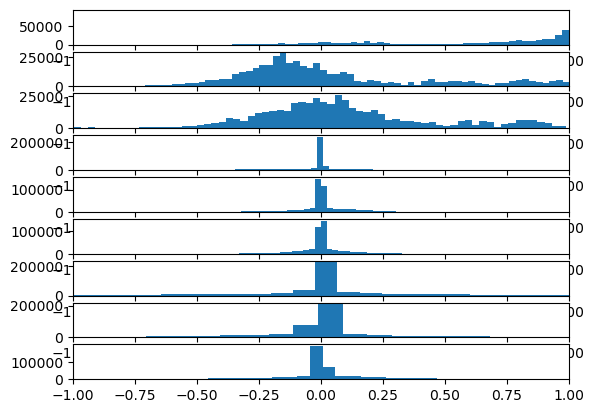

In [19]:
# plot distributions
plot_distributions(trainX)

In [20]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [21]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split,)

Epoch 1/10
92/92 [==============================] - 16s 148ms/step - loss: 1.2562 - accuracy: 0.4821 - val_loss: 1.0036 - val_accuracy: 0.6084
Epoch 2/10
92/92 [==============================] - 12s 129ms/step - loss: 0.8243 - accuracy: 0.6553 - val_loss: 0.8288 - val_accuracy: 0.6479
Epoch 3/10
92/92 [==============================] - 13s 138ms/step - loss: 0.7328 - accuracy: 0.7145 - val_loss: 0.7460 - val_accuracy: 0.7559
Epoch 4/10
92/92 [==============================] - 12s 136ms/step - loss: 0.5256 - accuracy: 0.7949 - val_loss: 0.6623 - val_accuracy: 0.7716
Epoch 5/10
92/92 [==============================] - 12s 135ms/step - loss: 0.5314 - accuracy: 0.8017 - val_loss: 0.6846 - val_accuracy: 0.7709
Epoch 6/10
92/92 [==============================] - 12s 132ms/step - loss: 0.3986 - accuracy: 0.8575 - val_loss: 0.5270 - val_accuracy: 0.8654
Epoch 7/10
92/92 [==============================] - 13s 138ms/step - loss: 0.2775 - accuracy: 0.9066 - val_loss: 0.4889 - val_accuracy: 0.8980

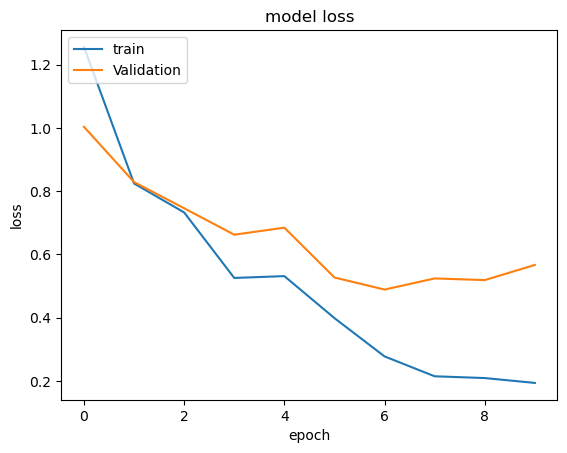

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [25]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)
     

Accuracy of the LSTM model 0.8669833540916443
93/93 [==============================] - 5s 48ms/step


In [26]:
predictions

array([[2.6824949e-03, 5.5330974e-04, 3.0234933e-04, 2.6230060e-02,
        9.7016925e-01, 6.2612431e-05],
       [2.2878132e-03, 6.1646546e-04, 2.9297874e-04, 2.3205856e-02,
        9.7353709e-01, 5.9805723e-05],
       [2.5676056e-03, 6.8308972e-04, 3.0783203e-04, 2.1543061e-02,
        9.7483724e-01, 6.1114268e-05],
       ...,
       [4.0599466e-03, 9.9177295e-01, 3.4406835e-03, 2.7006645e-05,
        6.9806463e-04, 1.3992976e-06],
       [1.0232924e-02, 9.7480416e-01, 9.5515726e-03, 2.7775887e-04,
        5.1116087e-03, 2.1989714e-05],
       [2.1525241e-02, 9.6873593e-01, 8.1000328e-03, 1.9568591e-04,
        1.4150116e-03, 2.8083143e-05]], dtype=float32)

In [27]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[479   3  11   1   2   0]
 [ 61 375  28   0   7   0]
 [ 20   9 385   0   6   0]
 [  0   2   0 417  70   2]
 [ 10   1   2 114 405   0]
 [  0  27  16   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.84      0.97      0.90       496
           2       0.90      0.80      0.84       471
           3       0.87      0.92      0.89       420
           4       0.78      0.85      0.82       491
           5       0.83      0.76      0.79       532
           6       1.00      0.92      0.96       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947



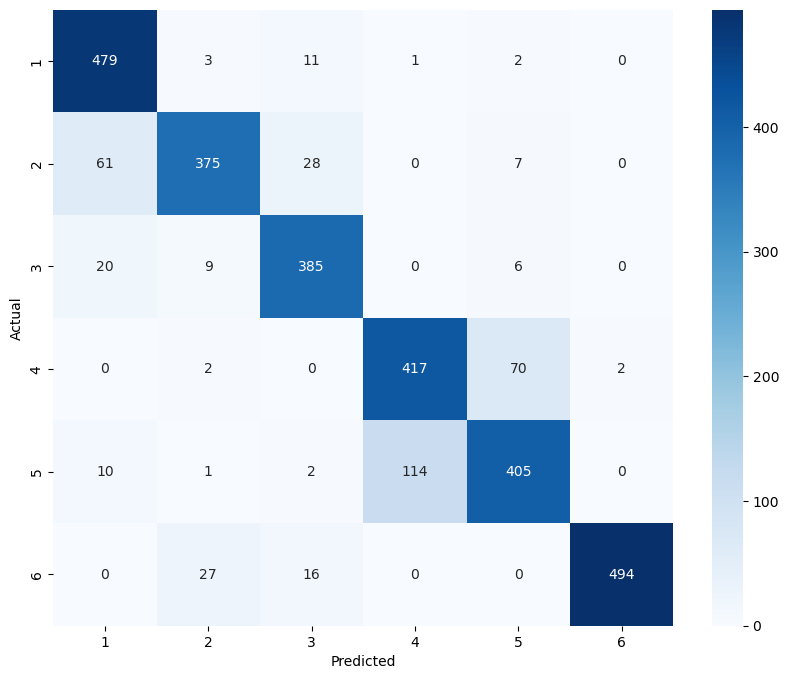

In [28]:

classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [29]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)
     

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split)

Epoch 1/20
92/92 [==============================] - 3s 25ms/step - loss: 0.5361 - accuracy: 0.7914 - val_loss: 0.4809 - val_accuracy: 0.8885
Epoch 2/20
92/92 [==============================] - 2s 23ms/step - loss: 0.1952 - accuracy: 0.9299 - val_loss: 0.3948 - val_accuracy: 0.9116
Epoch 3/20
92/92 [==============================] - 2s 22ms/step - loss: 0.1290 - accuracy: 0.9510 - val_loss: 0.3857 - val_accuracy: 0.9021
Epoch 4/20
92/92 [==============================] - 2s 22ms/step - loss: 0.1071 - accuracy: 0.9560 - val_loss: 0.3826 - val_accuracy: 0.9062
Epoch 5/20
92/92 [==============================] - 2s 22ms/step - loss: 0.0986 - accuracy: 0.9597 - val_loss: 0.3839 - val_accuracy: 0.9123
Epoch 6/20
92/92 [==============================] - 2s 22ms/step - loss: 0.0870 - accuracy: 0.9621 - val_loss: 0.3852 - val_accuracy: 0.9109
Epoch 7/20
92/92 [==============================] - 2s 25ms/step - loss: 0.0840 - accuracy: 0.9640 - val_loss: 0.4028 - val_accuracy: 0.9116
Epoch 8/20
92

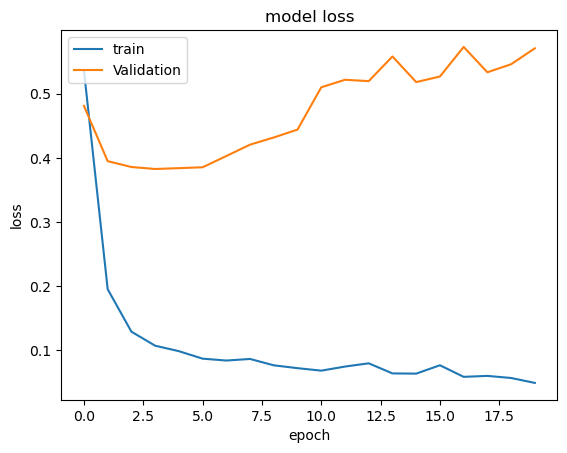

In [32]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [33]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.9046487808227539
93/93 [==============================] - 0s 4ms/step


**** Confusion Matrix ****
[[462   2  32   0   0   0]
 [  2 444  25   0   0   0]
 [  1   4 415   0   0   0]
 [  0   3   0 426  57   5]
 [  1   2   0 104 425   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.93      0.96       496
           2       0.89      0.94      0.92       471
           3       0.88      0.99      0.93       420
           4       0.80      0.87      0.83       491
           5       0.88      0.80      0.84       532
           6       0.99      0.92      0.95       537

    accuracy                           0.90      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.90      0.90      2947



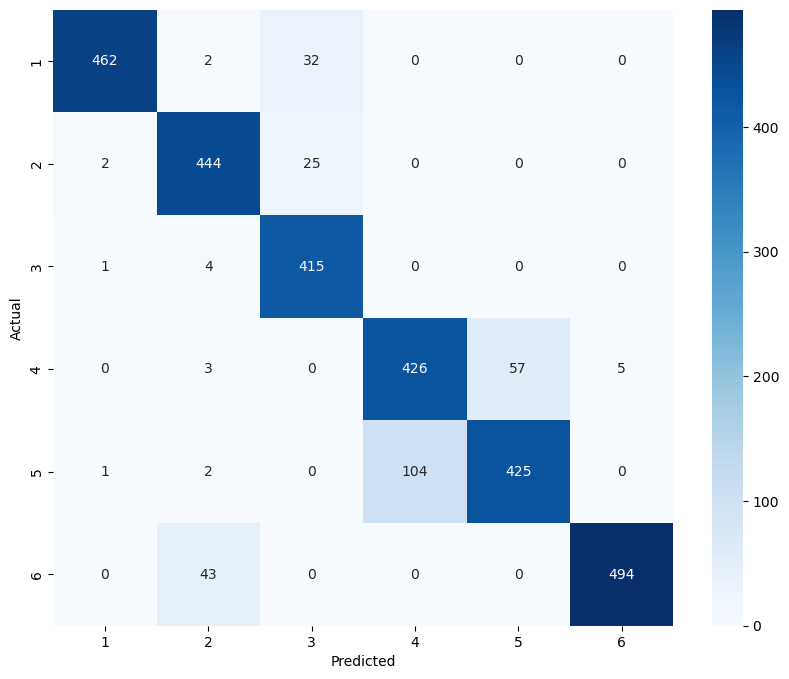

In [34]:
display_results(testy,predictions,classNames)

In [35]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [36]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 23ms/step


In [37]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
